In [49]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('./mbti_1.csv')
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [69]:
data.tail()

,type,posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...
8674,INFP,'It has been too long since I have been on per...


In [66]:
data.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [68]:
data.isnull().value_counts()

type   posts
False  False    8675
dtype: int64

In [84]:
data.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

The posts contain several links. These have been removed later on, and have not been replaced by any identifier like 'link' or 'http'. The reasoning being that the sentiment associated by the content of a link or the purpose behind sharing it cannot be captured by an identifier.

In [127]:
data.type[0]

'INFJ'

In [113]:
ptypes = list(data.type.unique())
print("Unique personality types:", ptypes)

Unique personality types: ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP', 'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']


In [6]:
typefreq = data["type"].value_counts()
print("Number of users per personality type\n", typefreq, sep='')

Number of users per personality type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


As we can see, this is a highly unbalanced dataset.

Text(0.5, 1.0, 'Number of users for each personality type')

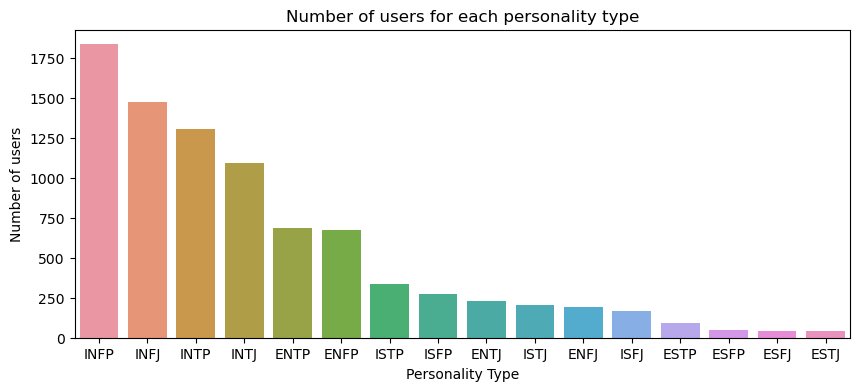

In [93]:
plt.figure(figsize=(10,4))
sns.barplot(x = typefreq.index, y = typefreq.values)
plt.xlabel("Personality Type")
plt.ylabel("Number of users")
plt.title("Number of users for each personality type")

In [111]:
sumtype = 0
minpost = 50
numlesspost = 0
numpost = [0]*len(ptypes)
for i in range(len(data)):
    post = data.posts[i]
    sumtype += 1
    lenpost = len(post.split('|||'))
    numpost[ptypes.index(data.type[i])] += lenpost
    if lenpost < 50:
        minpost = lenpost
        numlesspost += 1

In [83]:
print("Total no. of users: %d\nTotal no. of posts: %d\nUsers with less than 50 posts: %d \
      \nMin no. of posts for a user: %d" %(sumtype, sum(numpost), numlesspost, minpost))

Total no. of users: 8675
Total no. of posts: 422845
Users with less than 50 posts: 991       
Min no. of posts for a user: 37


We see that not all users' data contains all 50 posts.

In [107]:
#this function counts the no of words in each post of a user
def count(row):
    l = []
    # in each personality type - comments are separated by |||, thus split each row by the delimeter to get each comment and then count len of each comment
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.array([np.sum(l), np.var(l)])

#counts the no of words per comment out of the total posts in the whole row
ret = data['posts'].apply(lambda x: count(x))
ret = np.stack(ret.to_numpy())
data['words_per_comment'] = pd.Series(ret[:,0])
data['variance_of_word_counts'] = pd.Series(ret[:,1])

<AxesSubplot:xlabel='type', ylabel='words_per_comment'>

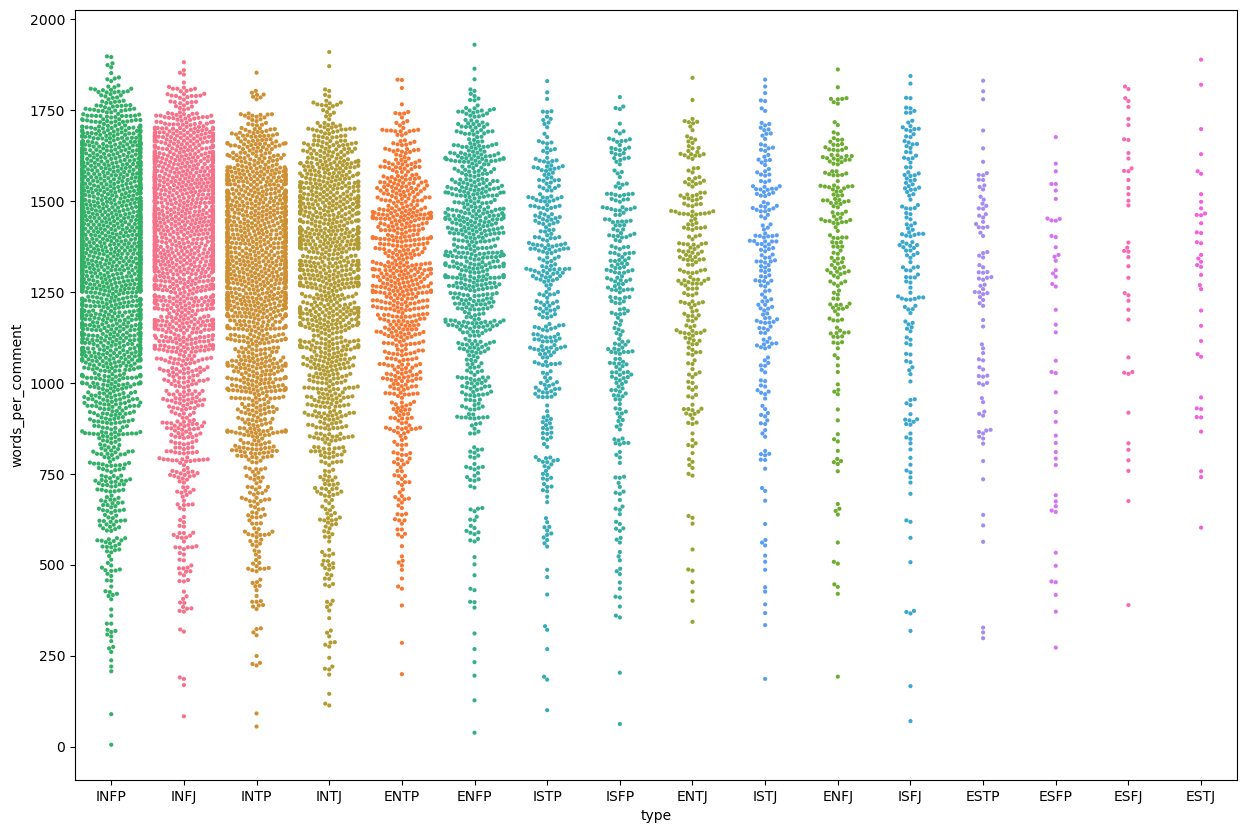

In [108]:
plt.figure(figsize=(15,10))
sns.swarmplot(data=data, x = "type", y = "words_per_comment", hue = "type", size = 3, order = typefreq.index, legend = False)

Text(0.5, 1.0, 'Distribution of Lengths of all 50 Posts')

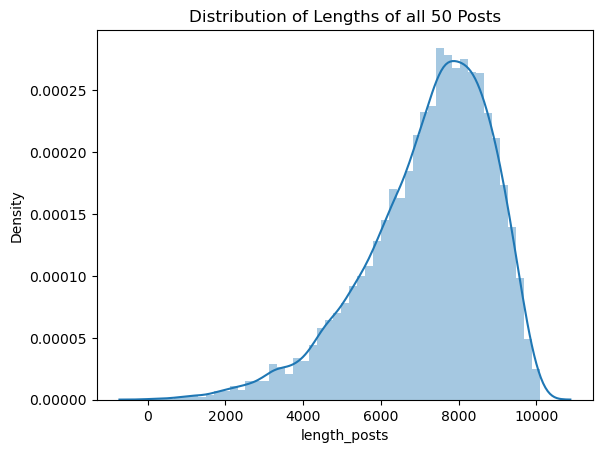

In [51]:
#Density Plot - Word Count by Posts => gives an overall picture of kernel density estimation

data["length_posts"] = data["posts"].apply(len)
sns.distplot(data["length_posts"]).set_title("Distribution of Lengths of all 50 Posts")

In [14]:
qs = np.quantile(data["length_posts"], [0.25, 0.75])
print("Most of the posts are between %d - %d words" %(qs[0], qs[1]))

Most of the posts are between 6325 - 8429 words


In [15]:
import nltk
from wordcloud import STOPWORDS
stop_words = set(STOPWORDS)

In [ ]:
words = [x.split("|||") for x in data["posts"]]
words = [x.split() for y in words for x in y]
words = [x.lower() for y in words for x in y]

In [33]:
print("Number of word before stopwords removal:", len(words))
words = [x for x in words if x not in stop_words]
print("Number of word after stopwords removal:", len(words))

Number of word before stopwords removal: 11050311
Number of word after stopwords removal: 5582382


In [44]:
frqdst = nltk.FreqDist(words)

In [47]:
most_common = frqdst.most_common(20)
most_common = np.array(most_common)
most_common

array([['think', '46706'],
       ['people', '38538'],
       ['really', '32153'],
       ['know', '31457'],
       ['one', '30315'],
       ['-', '23741'],
       ['feel', '21695'],
       ['much', '19295'],
       ['love', '18410'],
       ['want', '18132'],
       ['time', '18130'],
       ['good', '17685'],
       ['see', '17244'],
       ['say', '17090'],
       ['something', '16216'],
       ['always', '16097'],
       ['things', '16040'],
       ['even', '15819'],
       ['make', '15206'],
       ['never', '14529']], dtype='<U11')

<AxesSubplot:>

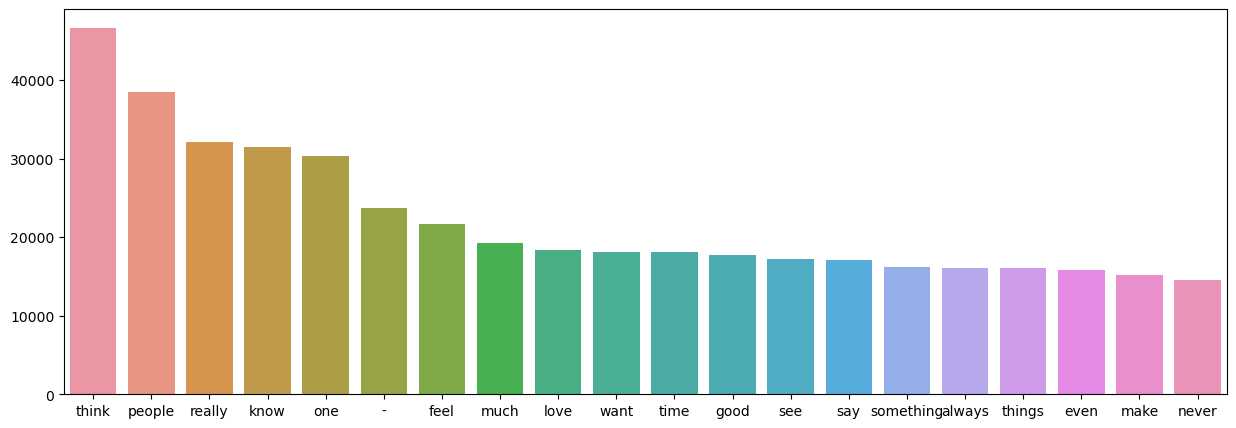

In [52]:
plt.figure(figsize=(15,5))
sns.barplot(x = most_common[:,0], y = most_common[:,1].astype(np.int))

These are the 20 most common words in the dataset vocabulary.

In [54]:
class MultilabelEncoder():
    def __init__(self):
        self.label_dict_ = {}
        self.group_list = [('I','E'), ('N','S'), ('T','F'), ('J','P')]
        
    def fit(self):
        for tup in self.group_list:
            for i in range(len(tup)):
                self.label_dict_[tup[i]] = i
    
    def transform(self, rawclasses:np.ndarray)->np.ndarray:
        if isinstance(rawclasses, str):
            rawclasses = np.array([rawclasses])
            
        if not (isinstance(rawclasses, np.ndarray) or isinstance(rawclasses, list)):
            raise Exception("Invalid datatype. Expect a list or array of strings.")
        
        labellist = []
        for cl in rawclasses:
            labelrow = []
            for ele in str(cl):
                labelrow.append(self.label_dict_[ele])
            labellist.append(labelrow)
        return np.array(labellist)
    
    def inverse_transform(self, labelrows:np.ndarray)->np.ndarray:
        if isinstance(labelrows, list):
            labelrows = np.array(labelrows)
        
        if not isinstance(labelrows, np.ndarray):
            raise Exception("Invalid datatype. Expect a list or array of multilabels.")
        
        if len(labelrows.shape) == 1:
            np.expand_dims(labelrows, axis=0)
            
        rawclasses = []
        for labelrow in labelrows:
            label = ""
            for i in range(len(labelrow)):
                label += self.group_list[i][labelrow[i]]
            rawclasses.append(label)
        return np.array(rawclasses)

In [55]:
lab_encoder = MultilabelEncoder()
lab_encoder.fit()

In [61]:
list_personality = lab_encoder.transform(data.type.values)

In [66]:
print("Introversion (I) /  Extroversion (E):\t",
      8675-list_personality[:,0].sum(), " / ", list_personality[:,0].sum())
print("Intuition (N) / Sensing (S):\t\t",
      8675-list_personality[:,1].sum(), " / ", list_personality[:,1].sum())
print("Thinking (T) / Feeling (F):\t\t",
      8675-list_personality[:,2].sum(), " / ", list_personality[:,2].sum())
print("Judging (J) / Perceiving (P):\t\t",
      8675-list_personality[:,3].sum(), " / ", list_personality[:,3].sum())

Introversion (I) /  Extroversion (E):	 6676  /  1999
Intuition (N) / Sensing (S):		 7478  /  1197
Thinking (T) / Feeling (F):		 3981  /  4694
Judging (J) / Perceiving (P):		 3434  /  5241


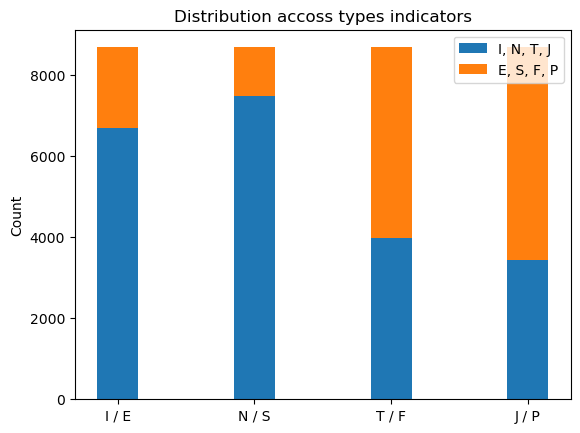

In [67]:
N = 4 #4 broad classifications

#count when the chars are 0 - indicating intoversion
bottom = (8675-list_personality[:,0].sum(), 8675-list_personality[:,1].sum(), 8675-list_personality[:,2].sum(), 8675-list_personality[:,3].sum())

#count when the chars are 1 - indicating extroversion 
top = (list_personality[:,0].sum(), list_personality[:,1].sum(), list_personality[:,2].sum(), list_personality[:,3].sum())

ind = np.arange(N)    # the x locations for the groups
# the width of the bars
width = 0.3           # or len(x) can also be used here

p1 = plt.bar(ind, bottom, width, label="I, N, T, J")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P") 

plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E',  'N / S', 'T / F', 'J / P',))
plt.legend()

plt.show()